# Selekcja i ekstrakcja cech za pomocą scikit-learn

Ten notatnik pomoże Ci zapoznać się z metodami przetwarzania wstępnego danych w Pythonie. Po uzupełnieniu tego notatnika powinieneś:

+ zapoznać się klasą Pipeline,
+ wiedzieć jak znormalizować dane,
+ umieć uruchomić algorytm selekcji cech,
+ wiedzieć jak wykonać analizę PCA

Wszystkie algorytmy będziemy uruchamiać na jednym zbiorze danych: [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

## Pipeline

Podczas przetwarzania wstępnego danych należy uważać, żeby nie korzystać z danych testowych. Wszakże jeśli nasz model zostanie uruchomiany na danych produkcyjnych będą to zupełnie nowe danych i nie będziemy zbyt dużo o nich wiedzieć w trakcie dokonywania predykcji.

Aby ułatwić użytkownikom biblioteki `scikit-learn` przetwarzanie wstępne z możliwością rozróżnienia danych treningowych od testowych, wprowadzono klasę `Pipeline`. Klasa `Pipeline` definiuje sekwencje kroków (transformacji), które należy wykonać na danych. Kolejnymi krokami pipeline'a mogą być:

- inżynieria nowych cech
- normalizacja danych
- usuwanie outlierów
- selekcja cech
- ekstrakcja cech
- uczenie klasyfikatora

Typowe pipeline'y są z reguły znacznie krótsze ;) Przydatna dokumentacja jak zwykle na stronie scikit-learn: [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

**Zad. 1: Załaduj wskazany zbiór danych i stwórz swój pierwszy pipeline. Pipeline powinien mieć dwa kroki: normalizację danych i uczenie regresora.**

In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np

SEED = 23

# 0. Zbiór danych
boston = load_boston()
X = boston["data"]
y = boston["target"]
names = boston["feature_names"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# 1. stwórz obiekt do normalizacji danych
scaler = StandardScaler()

# 2. stwórz klasyfikator
clf = RandomForestRegressor()

# 3. stwórz Pipeline z dwoma krokami, kroki nazwij "scaler" i "clf" i niech zawierają obiekty scaler i clf
pipe = Pipeline([('scaler', scaler), ('clf', clf)])

# 4. Odpal pipeline
clf_fit = pipe.fit(X_train, y_train)
y_true, y_pred = y_test, clf_fit.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %.4f" % rmse)

RMSE: 3.6494


`Pipeline` działa trochę jak klasyfikator połączony ze wstępnym przetwarzaniem. Można zatem podać stworzony przez siebie obiekt typu `Pipeline` jako parametr `GirdSearchCV`. Ale zanim do tego przejdziemy skupmy się na metodach selekcji cech.

## Selekcja cech

W poniższych sekcjach szybko spojrzymy na implementacje różnych metod selekcji cech w bibliotece `scikit-learn`. Warto zaznaczyć, że selekcja cech to bardzo szeroka działka naukowa i algorytmów jest multum. Stosunkowo niedawno pojawiła się biblioteka [`scikit-feature`](http://featureselection.asu.edu/), która rozszerza zbiór algorytmów dostępnych w `scikit-learn`. [`scikit-feature`](http://featureselection.asu.edu/) nie jest biblioteką, która jest oficjalnie wspierana przez ludzi tworzących `scikit-learn`, ale może to być dobre miejsce do poszukiwań implementacji mniej popularnych algorytmów.

### Metody filter

Zacznijmy od zbadania wariancji. Do tego przyda Ci się klasa [`Variancethreshold`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html). Jeśli wariancja jest zero (kolumna ma tylko jedną wartość) na pewno warto sprawdzić czy to nie jakiś błąd. Jeśli dana kolumna to po prostu stała, można ją z czystym sumieniem usunać. Mając rozeznanie w danych, można również ustawić minimalny próg zmienności.

**Zad. 2: Sprawdź czy w zbiorze danych są atrybuty o zmienności mniejszej niż 0.05.**

In [2]:
from sklearn.feature_selection import VarianceThreshold

# 1. Sprawdź ile atrybutów ma zbiór danych
print(f'Num of attributes: {X_train.shape[1]}')
# 2. Użyj metody fit_transform na obiekcie klasy VarianceThreshold
X_v = VarianceThreshold().fit_transform(X_train)
# 3. Sprawdź ile atrybutów ma przetransformowany zbiór danych
print(f'Num of attributes: {X_v.shape[1]}')

Num of attributes: 13
Num of attributes: 13


Inną prostą metodą jest badanie korelacji między zmiennymi a wartością przewidywaną. W `scikit-learn` służą do tego metody `chi2`, `f_classif` i `f_regression`. Ponieważ przewidujemy wartość ciągłą, sprawdźmy działanie tej ostatniej. Uwaga! Metody te oceniają każdą cechę osobno, dlatego cechy skorelowane będą podobnie ocenione.

**Zad. 3: Oceń atrybuty na podstawie ich korelacji z atrybutem decyzyjnym.**

In [3]:
from sklearn.feature_selection import f_regression

# 1. Odpalf_regression, aby uzyskać ocenę korelacji
f_scores, p_values = f_regression(X_train, y_train)

# 2. Wypisz wynik dla każdego atrybutu
for i in range(len(names)):
    print('{0}: {1:.2f} (p={2:.3f})'.format(names[i], f_scores[i], p_values[i]))

CRIM: 78.50 (p=0.000)
ZN: 63.28 (p=0.000)
INDUS: 106.05 (p=0.000)
CHAS: 12.59 (p=0.000)
NOX: 86.93 (p=0.000)
RM: 366.32 (p=0.000)
AGE: 72.51 (p=0.000)
DIS: 29.16 (p=0.000)
RAD: 67.46 (p=0.000)
TAX: 106.88 (p=0.000)
PTRATIO: 132.46 (p=0.000)
B: 55.38 (p=0.000)
LSTAT: 473.74 (p=0.000)


Znając korelację bądź inną wartość oceniającą atrybuty, możemy wybrać podzbioru najlepszych atrybutów. Do tego służą klasy `SelectKBest` i `SelectPercentile`



In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# 1. Stwórz obiekt SelectKBest z odpowiednimi parametrami
skb = SelectKBest(f_regression, k=10)
# 2. Stwórz pipeline z krokami scaler, selector i clf
pipe = Pipeline([('scaler', scaler), ('selector', skb), ('clf', clf)])
# 3. Odpal pipeline i oceń predykcje tak jak to zrobiłeś w zadaniu 1.
clf_fit = pipe.fit(X_train, y_train)
y_true, y_pred = y_test, clf_fit.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %.4f" % rmse)

RMSE: 3.8157


**Zad. 5: Powtórz poprzednie zadanie wykorzystując tym razem miarę `mutual_info_regression`.**

In [5]:
# 1. Stwórz obiekt SelectKBest z odpowiednimi parametrami
skb = SelectKBest(mutual_info_regression, k=10)
# 2. Stwórz pipeline z krokami scaler, selector i clf
pipe = Pipeline([('scaler', scaler), ('selector', skb), ('clf', clf)])
# 3. Odpal pipeline i oceń predykcje tak jak to zrobiłeś w zadaniu 1.
clf_fit = pipe.fit(X_train, y_train)
y_true, y_pred = y_test, clf_fit.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %.4f" % rmse)

RMSE: 3.6518


### Metody wrapper

Klasyczne metody typu wrapper nie są dostępne jako funkcje w `scikit-learn`. Można samemu zaimplementować brute-force, forward selction bądź backward selection lub... posiłkować się biblioteką [`mlxtend`](http://rasbt.github.io/mlxtend/) i zawartymi tam klasami `ExhaustiveFeatureSelector` (brute-force) i `SequentialFeatureSelector` (backward/foward selection). Biblioteka `mlxtend` zawiera wiele innych bardzo ciekawych rozszerzeń do `scikit-learn` (np. Stacking czy EnsembleVote) więc warto pamiętać o tej bibliotece.

Zamiast rozwodzić się nad klasycznymi metodami typu wrapper, które są bardzo kosztowne obliczeniowo, wypróbujmy algorytm RFE. Dla przypomnienia, algorytm RFE ocenia atrybuty a następnie usuwa najsłabszy z nich. Czynność ta jest powtarzana aż uzyskamy oczekiwaną liczbę atrybutów.


**Zad. 6: Skorzystaj z klasy [`RFECV`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) aby znaleźć najlepszy podzbiór atrybutów. Użyj 10-krotnej oceny krzyżowej.**

In [6]:
from sklearn.feature_selection import RFECV

# 1. Odpal RFECV na danych treningowych
selector = RFECV(clf, step=1, cv=10).fit(X_train, y_train)
# 2. Wypisz ranking atrybutów
for i in range(len(names)):
    print('{0}: {1}'.format(names[i], selector.ranking_[i]))

CRIM: 1
ZN: 4
INDUS: 2
CHAS: 5
NOX: 1
RM: 1
AGE: 1
DIS: 1
RAD: 3
TAX: 1
PTRATIO: 1
B: 1
LSTAT: 1


Bardzo fajną hybrydą jest również algorytm Stability Selection. Jest to algorytm dość kosztowny ale łączy elementy interpretacji atrybutów oraz poprawiania trafności predykcji. Zainteresowani mogą zajrzeć do klas [`RandomizedLogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLogisticRegression.html) (klasyfikacja) i [`RandomizedLasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLasso.html#sklearn.linear_model.RandomizedLasso) (regresja) w dokumentacji `scikit-learn`. Obie klasy są obecnie DEPRACATED, ale liczę że po prostu przeniosą je do modułu `feature_selection`.

### Metody embedded

Modele liniowe są od lat stosowane do określania ważności atrybutów. Modele liniowe bez regularyzacji potrafią wskazać ważność atrybutów jeśli dane nie są zbyt mocono zaszumione i atrybuty nie są ze sobą skorelowane.

Modele liniowe z regularyzacją radzą sobie lepiej z szumem i korelacją. Regularyzacja L1 (LASSO) usuwa atrybuty i może być stosowana do selekcji cech w celu poprawy trafności predykcji. Regularyzacja L2 (Ridge regression) jest bardzie stabilna, nie usuwa atrybutów i może być stosowania do oceny atrybutów w celach interpretacyjnych.

**Zad. 7: Naucz modele liniowe i sprawdź wagi przypisane kolejnym atrybutom by ocenić ich ważność. Nie zapomnij  oznormalizowaniu danych.**

In [7]:
from sklearn.linear_model import Lasso, Ridge

def pretty_print_linear(coefs, names = None, sort = False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) for coef, name in lst)

# 1. Odpal Lasso z alpha=0.3 w pipeline'ie z normalizacją
lasso = Lasso(alpha=0.3)
lasso_pipe = Pipeline([('scaler', scaler), ('lasso', lasso)])
lasso_pipe.fit(X_train, y_train)

# 2. Odpal Ridge z alpha=0.3 w pipeline'ie z normalizacją
ridge = Ridge(alpha=0.3)
ridge_pipe = Pipeline([('scaler', scaler), ('ridge', ridge)])
ridge_pipe.fit(X_train, y_train)

# 3. Wypisz uzyskane modele
print("Lasso model: ", pretty_print_linear(lasso_pipe.steps[1][1].coef_, names, sort = True))
print('-'*100)
print("Ridge model: ", pretty_print_linear(ridge_pipe.steps[1][1].coef_, names, sort = True))

Lasso model:  -3.797 * LSTAT + 3.003 * RM + -1.541 * PTRATIO + -1.024 * DIS + 0.883 * B + 0.746 * CHAS + -0.557 * NOX + 0.2 * ZN + -0.061 * CRIM + -0.0 * INDUS + -0.0 * AGE + 0.0 * RAD + -0.0 * TAX
----------------------------------------------------------------------------------------------------
Ridge model:  -3.794 * LSTAT + -3.047 * DIS + 2.772 * RM + 2.389 * RAD + -2.159 * NOX + -1.88 * PTRATIO + -1.555 * TAX + 1.149 * B + 1.109 * ZN + 0.864 * CHAS + -0.797 * CRIM + 0.167 * INDUS + 0.055 * AGE


## Ekstrakcja cech

Na koniec zobaczymy jak w Pythonie policzyć PCA i na tej podstawie zmniejszyć liczbę atrybutów. Uwaga! Trzeba znormalizować dane przed analizą PCA, aby nie przecenić atrybutów o większym zakresie wartości i wten sposób nie wykonać gorszej transformacji.

**Zad. 8: Wykonaj analizę PCA zgodnie z poniższymi krokami.**

RMSE: 4.0527


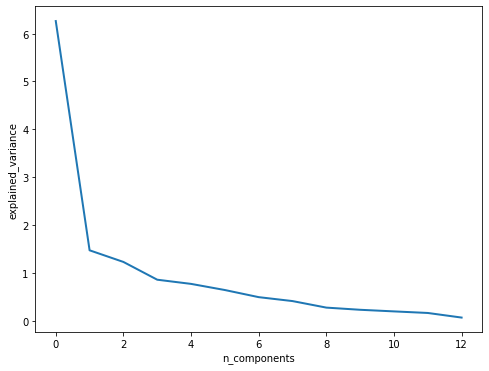

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Znormalizuj dane, odpal PCA i zobacz ile atrybutów potrzeba do wyjaśnienia zmienności w danych
pca = Pipeline([('scaler', scaler), ('extractor', PCA())])
pca.fit(X_train)

plt.figure(1, figsize=(8, 6))
plt.plot(pca.steps[1][1].explained_variance_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance')

# 2. Stwórz nowy obiekt PCA i ogranicz liczbę cech do określonej na podstawie wykresu liczby
pca = PCA(n_components=10)
# 3. Stwórz pipeline z krokami scaler, extractor i clf
pipe = Pipeline([('scaler', scaler), ('extractor', pca), ('clf', clf)])
# 4. Odpal pipeline i oceń predykcje tak jak to zrobiłeś w zadaniu 1.
clf_fit = pipe.fit(X_train, y_train)
y_true, y_pred = y_test, clf_fit.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %.4f" % rmse)

## Zadanie bonusowe

**Zad. 9*: Zaimplementuj grid search, który wypróbuje wiele metod selekcji cech (potencjalnie z różnymi parametrami) i wybierze najlepsze wstępne przetwarzanie danych.**

In [9]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

pipe = Pipeline([
    ('scaler', None),
    ('extractor', None),
    ('feature_selection', None),
    ('clf', RandomForestRegressor())])

parameters = dict(
    scaler = ['passthrough', StandardScaler(), RobustScaler()],
    extractor = [PCA()],
    extractor__n_components = [5, 10 , 13],
    feature_selection = ['passthrough', Lasso(), Ridge()],
    clf__n_estimators = [100, 150],
    clf__random_state = [1337]
)

clf = GridSearchCV(pipe, parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)
print('-'*100)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))}")

{'clf__n_estimators': 150, 'clf__random_state': 1337, 'extractor': PCA(n_components=13), 'extractor__n_components': 13, 'feature_selection': 'passthrough', 'scaler': 'passthrough'}
----------------------------------------------------------------------------------------------------
RMSE: 3.9995010721209634
